<a href="https://colab.research.google.com/github/limyansky/Personality-Classification/blob/main/Embed_Sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Personality Types with Machine Learning

This notebook uses TensorFlow and Sentence-BERT to determine a person's Big 5 personality traits from short stream of consciousness essays.

Install the `sentence-transformers` package from huggingface. This includes the Sentence-BERT model we will be using.

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=9c027a6da4e5dc3e0f5979c700237a5d80e447093b3d336a057f5e03a2c0cc6e
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pickle

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD, PCA

from sentence_transformers import SentenceTransformer

import nltk
from tqdm import tqdm
from collections import defaultdict

# Data Processing

- Split each paragraph into a list of sentences.
- Embed each sentence into 384 dimensional space using Sentence-BERT
- Convert 'y/n' tags into binary '1/0' tags
- Combine the 5 binary tags into 32 distinct personality types
  - The result is a 5 digit binary number, with the bits representing:  
  [EXT, NEU, AGR, CON, OPN]

In [ ]:
# Sentence-BERT for embedding
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# used to split paragraphs into sentences
nltk.download('punkt')

# Enables progress bars for Pandas
tqdm.pandas()

# Pipeline Functions
class parse_paragraphs(BaseEstimator, TransformerMixin):
  """ Split paragraphs into lists of sentences.

  Adds 'sentences', a list of individual sentences.
  Adds 'embeddings', a list of sentence embeddings
  """
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    X['sentences'] = X.progress_apply(lambda row: 
                                          nltk.sent_tokenize(row.TEXT),
                                      axis=1)
    X['embeddings'] = X.progress_apply(lambda row: 
                                          model.encode(row.sentences),
                                        axis=1)
    
    return X


class y_n_binarize(BaseEstimator, TransformerMixin):
  """ Convert 'y' or 'n' tags into '1' and '0' tags, respectively.
  """
  def __init__(self, columns):
    self.columns = columns

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for col_name in self.columns:
      output = []
      for element in X[col_name]:
        if element == 'y':
          output.append(1)
        elif element == 'n':
          output.append(0)

      X[col_name] = output

    return X

class dropColumn(BaseEstimator, TransformerMixin):
  """ Drops columns from dataframe.
  """

  def __init__(self, columns):
    self.columns = columns

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = X.drop(self.columns, axis=1)
    return X

class find_category(BaseEstimator, TransformerMixin):
  """ Convert the 5 binary personality types to 1 of 32 distinct combinations
  """
  def __init__(self, columns):
    self.columns = columns

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X['category'] = X.progress_apply(lambda row: 
                                      self.make_category(row, self.columns),
                                      axis=1)
    return X
  
  def make_category(self, row, columns):
    # https://stackoverflow.com/questions/38935169/convert-elements-of-a-list-into-binary
    binary_list = []
    for column in columns:
      binary_list.append(getattr(row, column))
    return int(''.join(map(str, binary_list)), 2)

In [ ]:
# Loads the Essays dataset
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Personality_Types/Data/essays.csv')

to_binarize = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
paragraph = ['TEXT']

# Pipeline for labels
yPipe = Pipeline([
    ('binarize', y_n_binarize(to_binarize)),
    ('single category', find_category(to_binarize))
])

# Pipeline for features
XPipe = Pipeline([
    ('embedding', parse_paragraphs()),
    ('dropping', dropColumn(paragraph))
])

raw_data = yPipe.fit_transform(raw_data)
raw_data = XPipe.fit_transform(raw_data)

# Save the processed data
raw_data.to_pickle('/content/drive/MyDrive/Colab Notebooks/Personality_Types/Processed_Data/essays_embedded.pkl')

100%|██████████| 2467/2467 [01:14<00:00, 33.15it/s]


In [ ]:
# Load the processed data
processed_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Personality_Types/Processed_Data/essays_embedded.pkl')

## Train and Test Datasets
I use a stratified shuffle split along the 32 unique personality types to ensure that each has porportionally appropriate representation.

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=66)
categories = processed_data['category']

for train_index, test_index in split.split(processed_data, categories):
  train_set = processed_data.iloc[train_index]
  test_set = processed_data.iloc[test_index]

# Quick Visualizations and Statistics

Each individual personality category is pretty close to an even split, as the mean of these columns is around 0.5. 

In [ ]:
train_set.describe()

,cEXT,cNEU,cAGR,cCON,cOPN,category
count,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000
mean,0.517486,0.499747,0.530157,0.508363,0.514952,15.930056
std,0.499821,0.500127,0.499216,0.500057,0.499903,8.824361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,16.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000


However, taken as a whole, certain personality types are much more common than others.   


<Axes: >

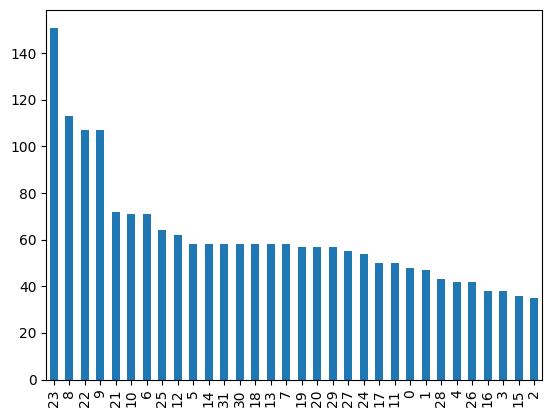

In [ ]:
train_set['category'].value_counts().plot(kind='bar')

In [ ]:
print('Total Counts: ', len(train_set))
print()
train_set['category'].value_counts()

Total Counts:  1973



23    151
8     113
22    107
9     107
21     72
10     71
6      71
25     64
12     62
5      58
14     58
31     58
30     58
18     58
13     58
7      58
19     57
20     57
29     57
27     55
24     54
17     50
11     50
0      48
1      47
28     43
4      42
26     42
16     38
3      38
15     36
2      35
Name: category, dtype: int64

If we look at the binary representations of the most represented categories, we can see that the six most represented categories are inverses of eachother.

23: 10111  
8 : 01000  


---


22: 10110  
9 : 01001  


---


21: 10101  
10 : 01010

# Work with the Data
I had originally planed to work with two main categories of data: sentence-level, and paragraph-level. Sentence-level would include a separate embedding for each sentence, and the paragraph-level would be the result of averaging all sentences in the paragraph together. To get this project out the door a little faster, I ended up only working with the paragraph-level data. However, processing for the sentence-level data is still included.

# SIF Embedding
I impliment an analogue to [SIF Embedding](https://openreview.net/pdf?id=SyK00v5xx).
After some testing with random forests, I determined that it did not improve my results. I leave the code in my notebook, because I had fun with it, but you can skip it without losing anything.

SIF Embedding is one solution to the task of combining word-level embeddings into embeddings for sentences and paragraphs. Word-level embeddings, such as [GloVe](https://nlp.stanford.edu/projects/glove/), map individual words to a high-dimensional vector space. This mapping is such that the dot-product of two word vectors directly related to the probability that the words appear together in a corpus of text. However, this training method as an unfortunate side-effect: relatively useless words, such as "the", "a", etc., which are paired with a large number of different words, end up with a large magnitude when vectorized. If one were to attempt to simply take the average of all the words in a sentence, these filler words would end up dominating the result. 

SIF embedding tackels this a few steps: 
- Weight each word in a matter inversely porportional to how frequently it occurs in your corpus of text.
- Create sentence embeddings by averaging the words in each sentence, subject to this inverse weighting.
- Looking at _all_ the sentences, find the first principal component.
- Remove the projection each sentence onto the principal component.

In hindsight, finding that SIF embedding did not help my classifiers is not surprising. Sentence-BERT was trained so that similar sentences should have a high cosine-similarity and low Euclidian distance. Words which dont affect the meaning of the sentence will thus have their importance automatically diminshed during training.

My analogue to SIF-Embedding only includes subtraction of various principal components, and does not do any sort of re-weighting.
I find the principal axes by examining both the training and validation sets simultaneously.


In [ ]:
# Split the data into sentences and paragraphs, as well as split
# features from labels.
def prep_data(data_set):

  trimmed_data = data_set.drop(labels = ['sentences', '#AUTHID'], axis=1)
  train_sentences = trimmed_data.explode('embeddings')

  # Expand paragraphs into sentence-level data
  X_sentences = train_sentences.drop(labels=['cEXT', 'cNEU', 'cAGR', 'cCON',
                                           'cOPN', 'category'], axis=1)
  X_sentences = pd.DataFrame(X_sentences['embeddings'].to_list())
  y_sentences = train_sentences.drop(labels=['embeddings'], axis=1)

  # Compress paragraphs into single embedding via mean
  trimmed_data['embeddings'] = trimmed_data['embeddings'].apply(lambda x: np.mean(x, axis=0))
  X_paragraphs = trimmed_data.drop(labels=['cEXT', 'cNEU', 'cAGR', 'cCON',
                                          'cOPN', 'category'], axis=1)
  X_paragraphs = pd.DataFrame(X_paragraphs['embeddings'].to_list())
  y_paragraphs = trimmed_data.drop(labels=['embeddings'], axis=1)

  return X_sentences, y_sentences, X_paragraphs, y_paragraphs

# All the training data
X_sent_master, _, X_para_master, _ = prep_data(train_set)

After creating a dataset of all the training and validation sentences, I go about actually creating the training and validation datasets.

In [ ]:
# Training and Validation Indices
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=66)
categories = train_set['category']

for train_index, valid_index in split.split(train_set, categories):
  train_set_2 = train_set.iloc[train_index]
  valid_set = train_set.iloc[valid_index]

X_sent_train, y_sent_train, X_para_train, y_para_train = prep_data(train_set_2)
X_sent_valid, y_sent_valid, X_para_valid, y_para_valid = prep_data(valid_set)

Let's double check that our splitting behaved as expected.



In [ ]:
print("Test Set Length: ", len(test_set))
print("Train Set Length: ", len(train_set_2))
print("Valid Set Length: ", len(valid_set))
print("Total Length: ", len(test_set)+ len(train_set_2) + len(valid_set))
print("Input Data Length: ", len(processed_data))

Test Set Length:  494
Train Set Length:  1578
Valid Set Length:  395
Total Length:  2467
Input Data Length:  2467


In [ ]:
# Are any of the same elements in multipel datasets? 

def pull_locs(pd_dataFrame):
  output = []
  for index, row in pd_dataFrame.iterrows():
    output.append(int(row.name))
  return output

test_locs = pull_locs(test_set)
train_locs = pull_locs(train_set_2)
valid_locs = pull_locs(valid_set)

In [ ]:
loc_vector = [test_locs, train_locs, valid_locs]

for ii in loc_vector:
  for jj in loc_vector:
    print(np.any(np.isin(ii, jj)))
  print()

True
False
False

False
True
False

False
False
True



As expected, each set is in itsself, but not in the others. 

I perform the SIF embedding below.

In [ ]:
# Perform the SIF embedding
# https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py
def sif_embed(masterData, trainData, validData, n_components):
  """ Removes most prominant axis from pandas dataframe. 

  masterData = trainData + validData, i.e. fit the most prominatnt axis to ALL data.
  trainData: the training data from which the master axis should be subtracted
  validData: the validation data from which the amster axis should be subtracted
  """

  # Find most prominant axis of the entire dataset
  svd = TruncatedSVD(n_components=n_components)
  svd.fit(masterData)

  # Perform the subtraction
  trainData = trainData.to_numpy()
  validData = validData.to_numpy()

  if n_components == 1:
    trainData_sub = trainData - (trainData.dot(svd.components_.transpose())*svd.components_)
    validData_sub = validData - (validData.dot(svd.components_.transpose())*svd.components_)
  else:
    trainData_sub = trainData - (trainData.dot(svd.components_.transpose()).dot(svd.components_))
    validData_sub = validData - (validData.dot(svd.components_.transpose()).dot(svd.components_))

  return trainData_sub, validData_sub

X_sent_train_SIF_1, X_sent_valid_SIF_1 = sif_embed(X_sent_master, X_sent_train, X_sent_valid, 1)
X_sent_train_SIF_5, X_sent_valid_SIF_5 = sif_embed(X_sent_master, X_sent_train, X_sent_valid, 5)
X_sent_train_SIF_25, X_sent_valid_SIF_25 = sif_embed(X_sent_master, X_sent_train, X_sent_valid, 25)

X_para_train_SIF_1, X_para_valid_SIF_1 = sif_embed(X_para_master, X_para_train, X_para_valid, 1)
X_para_train_SIF_5, X_para_valid_SIF_5 = sif_embed(X_para_master, X_para_train, X_para_valid, 5)
X_para_train_SIF_25, X_para_valid_SIF_25 = sif_embed(X_para_master, X_para_train, X_para_valid, 25)


### Visualizing the SIF Embedding
Using PCA, I project the data onto the most relevant two axes and plot it. It is interesting to see how the data becomes compactified as components are removed, which is exactly the expected behaviour. 

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


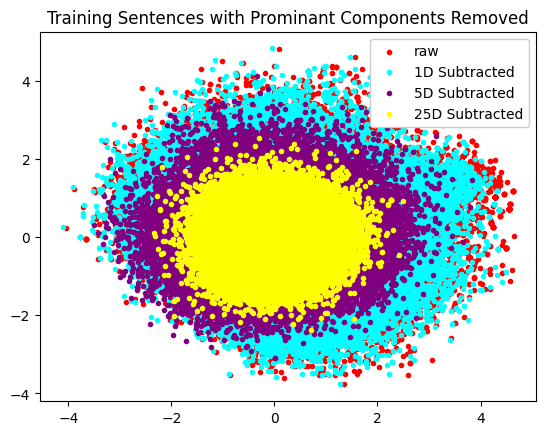

In [ ]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X_sent_train)

X2D_SIF_1 = pca.fit_transform(X_sent_train_SIF_1)
X2D_SIF_5 = pca.fit_transform(X_sent_train_SIF_5)
X2D_SIF_25 = pca.fit_transform(X_sent_train_SIF_25)

alpha = 1

plt.scatter(X2D[:,0], X2D[:, 1], alpha=alpha, marker='.', color='red', label='raw')
plt.scatter(X2D_SIF_1[:,0], X2D_SIF_1[:, 1], alpha=alpha, marker='.', color='cyan', label='1D Subtracted')
plt.scatter(X2D_SIF_5[:,0], X2D_SIF_5[:, 1], alpha=alpha, marker='.', color='purple', label='5D Subtracted')
plt.scatter(X2D_SIF_25[:,0], X2D_SIF_25[:, 1], alpha=alpha, marker='.', color='yellow', label='25D Subtracted')
plt.legend(framealpha=1)
plt.title('Training Sentences with Prominant Components Removed')
plt.show()

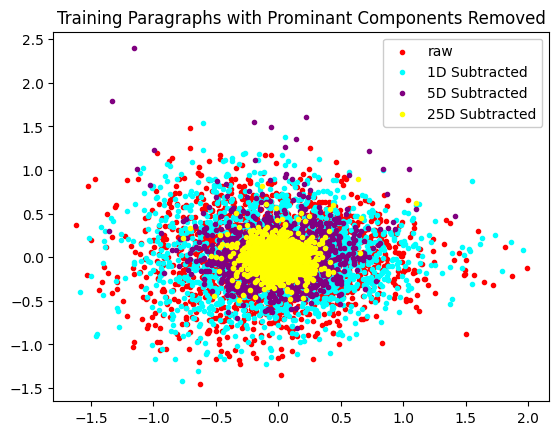

In [ ]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X_para_train)

X2D_SIF_1 = pca.fit_transform(X_para_train_SIF_1)
X2D_SIF_5 = pca.fit_transform(X_para_train_SIF_5)
X2D_SIF_25 = pca.fit_transform(X_para_train_SIF_25)

alpha = 1

plt.scatter(X2D[:,0], X2D[:, 1], alpha=alpha, marker='.', color='red', label='raw')
plt.scatter(X2D_SIF_1[:,0], X2D_SIF_1[:, 1], alpha=alpha, marker='.', color='cyan', label='1D Subtracted')
plt.scatter(X2D_SIF_5[:,0], X2D_SIF_5[:, 1], alpha=alpha, marker='.', color='purple', label='5D Subtracted')
plt.scatter(X2D_SIF_25[:,0], X2D_SIF_25[:, 1], alpha=alpha, marker='.', color='yellow', label='25D Subtracted')
plt.legend(framealpha=1)
plt.title('Training Paragraphs with Prominant Components Removed')
plt.show()

# Classifiers  
I will use a random forest classifier from scikit-learn, as well as two different neural network classifiers I create using TensorFlow.

### Random Forest
[Random forests](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) are a great starting point, because they: 
- Can work on unscaled data  
- Can [estimate error](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#:~:text=The%20out%2Dof%2Dbag%20(,whilst%20being%20trained%20%5B1%5D) during training, without the need for a validaton set
- Have very easy-to-play-with hyperparameters
  - The number of trees can be increased arbitrairly without needing to worry about overfitting
  - The number of features to consider at each split has good rules of thumb (in this case, $\sqrt{\mathrm{features}}$)
  - Bootstrapping (?) allows us to increase the number of trees rapidly, re-using previous calculations.

I begin looking at the random forests by examining how many trees I should include in my ensemble. I found this scan to be a little noisy, so I perform it 5 times and take the average at each position where the number of trees is the same.


Iteration:  0


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]



Iteration:  1


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]



Iteration:  2


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]



Iteration:  3


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]



Iteration:  4


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


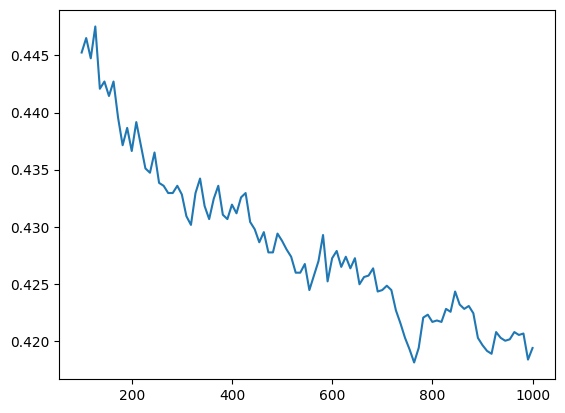

In [ ]:
estimator_length = np.linspace(100, 1000, 100)

training_datasets = [X_para_train, X_para_train_SIF_1, X_para_train_SIF_5, X_para_train_SIF_25]
validation_datasets = [X_para_valid, X_para_valid_SIF_1, X_para_valid_SIF_5, X_para_valid_SIF_25]

def scan_estimators(dataset, labels, estimator_length, iterations=1):
  """ Stuff
  """
  errors = np.zeros((iterations, len(estimator_length)))

  for ii in range(iterations):
    print()
    print('Iteration: ', str(ii))
    rf_clf = RandomForestClassifier(warm_start = True,
                                      oob_score=True,
                                      max_features="sqrt",
                                      n_jobs=-1,
                                      verbose=False)

    for index, n_estimator in enumerate(tqdm(estimator_length)):
      rf_clf.set_params(n_estimators=int(n_estimator))
      rf_clf.fit(dataset, labels)
      errors[ii, index] = (1 - rf_clf.oob_score_)

  errors_mean = np.mean(errors, axis=0)
  return errors_mean

estimator_length = np.linspace(100, 1000, 100)
errors_para = scan_estimators(X_para_train, y_para_train['cNEU'], estimator_length, 5)

plt.plot(estimator_length, errors_para)
plt.show()

This looks like it levels out at perhaps around 800 trees. Lets take another look, including the datasets with different numbers of principal components removed.

In [ ]:
estimator_length = np.linspace(100, 1000, 25)
errors_para = scan_estimators(X_para_train, y_para_train['cNEU'], estimator_length, 5)
errors_para_SIF_1  = scan_estimators(X_para_train_SIF_1, y_para_train['cNEU'], estimator_length, 5)
errors_para_SIF_5  = scan_estimators(X_para_train_SIF_5, y_para_train['cNEU'], estimator_length, 5)
errors_para_SIF_25 = scan_estimators(X_para_train_SIF_25, y_para_train['cNEU'], estimator_length, 5)

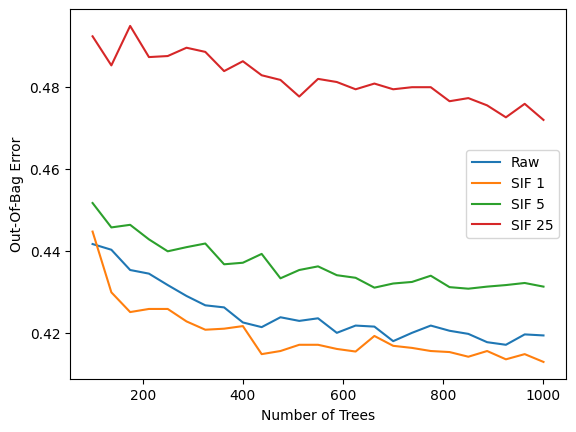

In [ ]:
plt.plot(estimator_length, errors_para, label='Raw')
plt.plot(estimator_length, errors_para_SIF_1, label='SIF 1')
plt.plot(estimator_length, errors_para_SIF_5, label='SIF 5')
plt.plot(estimator_length, errors_para_SIF_25, label='SIF 25')

plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Out-Of-Bag Error')
plt.show()

800 seems like an okay point to limit the number of trees, if a bit on the conservative side. It also looks like removing the first principal component may improve the results. Removing 5 and 25 components is definitely too much, and it is interesting to see the degridation. Let's take a look at removing between 1 and 5 principal components, to see if 1 is really preferred.


Iteration:  0


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]



Iteration:  1


100%|██████████| 25/25 [00:40<00:00,  1.63s/it]



Iteration:  2


100%|██████████| 25/25 [00:32<00:00,  1.30s/it]



Iteration:  3


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]



Iteration:  4


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]



Iteration:  0


100%|██████████| 25/25 [00:31<00:00,  1.24s/it]



Iteration:  1


100%|██████████| 25/25 [00:29<00:00,  1.16s/it]



Iteration:  2


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]



Iteration:  3


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]



Iteration:  4


100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


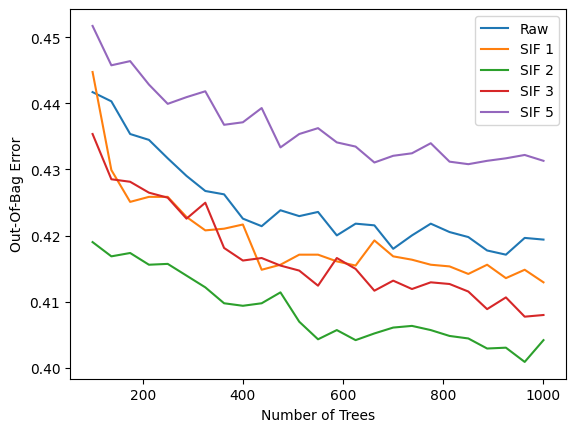

In [ ]:
X_para_train_SIF_2, X_para_valid_SIF_2 = sif_embed(X_para_master, X_para_train, X_para_valid, 2)
X_para_train_SIF_3, X_para_valid_SIF_3 = sif_embed(X_para_master, X_para_train, X_para_valid, 3)

estimator_length = np.linspace(100, 1000, 25)
errors_para_SIF_2  = scan_estimators(X_para_train_SIF_2, y_para_train['cNEU'], estimator_length, 5)
errors_para_SIF_3  = scan_estimators(X_para_train_SIF_3, y_para_train['cNEU'], estimator_length, 5)

plt.plot(estimator_length, errors_para, label='Raw')
plt.plot(estimator_length, errors_para_SIF_1, label='SIF 1')
plt.plot(estimator_length, errors_para_SIF_2, label='SIF 2')
plt.plot(estimator_length, errors_para_SIF_3, label='SIF 3')
plt.plot(estimator_length, errors_para_SIF_5, label='SIF 5')


plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Out-Of-Bag Error')
plt.show()

This suggests that two may really be the best. However, the out-of-bag error may not be as good at testing this, [particularly](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0201904) with a low number of examples in a large feature space. Let's use a traditional validation set instead.

In [ ]:
rf_clf_para_cNEU = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_SIF_1_cNEU = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_SIF_2_cNEU = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_cNEU.fit(X_para_train, y_para_train['cNEU'])
rf_clf_para_SIF_1_cNEU.fit(X_para_train_SIF_1, y_para_train['cNEU'])
rf_clf_para_SIF_2_cNEU.fit(X_para_train_SIF_2, y_para_train['cNEU'])



RandomForestClassifier(n_estimators=800, n_jobs=-1, oob_score=True,
                       warm_start=True)

In [ ]:
print(1-rf_clf_para_cNEU.oob_score_)
print(1-rf_clf_para_SIF_1_cNEU.oob_score_)
print(1-rf_clf_para_SIF_2_cNEU.oob_score_)

0.4207858048162231
0.4226869455006337
0.41381495564005066


In [ ]:
y_para_pred = rf_clf_para_cNEU.predict(X_para_valid)
y_para_pred_SIF_1 = rf_clf_para_SIF_1_cNEU.predict(X_para_valid_SIF_1)
y_para_pred_SIF_2 = rf_clf_para_SIF_2_cNEU.predict(X_para_valid_SIF_2)

accuracy_raw = accuracy_score(y_para_valid['cNEU'], y_para_pred)
accuracy_SIF_1 = accuracy_score(y_para_valid['cNEU'], y_para_pred_SIF_1)
accuracy_SIF_2 = accuracy_score(y_para_valid['cNEU'], y_para_pred_SIF_2)

f1_raw = f1_score(y_para_valid['cNEU'], y_para_pred)
f1_SIF_1 = f1_score(y_para_valid['cNEU'], y_para_pred_SIF_1)
f1_SIF_2 = f1_score(y_para_valid['cNEU'], y_para_pred_SIF_2)

print(accuracy_raw)
print(accuracy_SIF_1)
print(accuracy_SIF_2)
print()

print(f1_raw)
print(f1_SIF_1)
print(f1_SIF_2)

0.610126582278481
0.6025316455696202
0.569620253164557

0.6010362694300518
0.5922077922077922
0.5502645502645503


According to these validation errors, it looks like the SIF embedding may help a _little_ at the sentence level (although, that could just be noise), and looks to make things worse at the paragraph level. I will compare removing the first principal component across different personality types, just to be sure.

In [ ]:
rf_clf_para_cEXT = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cNEU = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cAGR = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cCON = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cOPN = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

### SIF_1 Classifiers ###
rf_clf_para_SIF_1_cEXT = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_SIF_1_cNEU = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_SIF_1_cAGR = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_SIF_1_cCON = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)

rf_clf_para_SIF_1_cOPN = RandomForestClassifier(max_features="sqrt",
                                                warm_start=True,
                                                oob_score=True,
                                                n_jobs=-1,
                                                n_estimators=800)




In [ ]:
### Training the Classifiers ###
rf_clf_para_cEXT.fit(X_para_train, y_para_train['cEXT'])
rf_clf_para_cNEU.fit(X_para_train, y_para_train['cNEU'])
rf_clf_para_cAGR.fit(X_para_train, y_para_train['cAGR'])
rf_clf_para_cCON.fit(X_para_train, y_para_train['cCON'])
rf_clf_para_cOPN.fit(X_para_train, y_para_train['cOPN'])

rf_clf_para_SIF_1_cEXT.fit(X_para_train_SIF_1, y_para_train['cEXT'])
rf_clf_para_SIF_1_cNEU.fit(X_para_train_SIF_1, y_para_train['cNEU'])
rf_clf_para_SIF_1_cAGR.fit(X_para_train_SIF_1, y_para_train['cAGR'])
rf_clf_para_SIF_1_cCON.fit(X_para_train_SIF_1, y_para_train['cCON'])
rf_clf_para_SIF_1_cOPN.fit(X_para_train_SIF_1, y_para_train['cOPN'])


In [ ]:
y_para_pred_cEXT = rf_clf_para_cEXT.predict(X_para_valid)
y_para_pred_cNEU = rf_clf_para_cNEU.predict(X_para_valid)
y_para_pred_cAGR = rf_clf_para_cAGR.predict(X_para_valid)
y_para_pred_cCON = rf_clf_para_cCON.predict(X_para_valid)
y_para_pred_cOPN = rf_clf_para_cOPN.predict(X_para_valid)

y_para_pred_cEXT_SIF_1 = rf_clf_para_SIF_1_cEXT.predict(X_para_valid_SIF_1)
y_para_pred_cNEU_SIF_1 = rf_clf_para_SIF_1_cNEU.predict(X_para_valid_SIF_1)
y_para_pred_cAGR_SIF_1 = rf_clf_para_SIF_1_cAGR.predict(X_para_valid_SIF_1)
y_para_pred_cCON_SIF_1 = rf_clf_para_SIF_1_cCON.predict(X_para_valid_SIF_1)
y_para_pred_cOPN_SIF_1 = rf_clf_para_SIF_1_cOPN.predict(X_para_valid_SIF_1)


In [ ]:
print(accuracy_score(y_para_valid['cEXT'], y_para_pred_cEXT))
print(accuracy_score(y_para_valid['cNEU'], y_para_pred_cNEU))
print(accuracy_score(y_para_valid['cAGR'], y_para_pred_cAGR))
print(accuracy_score(y_para_valid['cCON'], y_para_pred_cCON))
print(accuracy_score(y_para_valid['cOPN'], y_para_pred_cOPN))

print()
print(accuracy_score(y_para_valid['cEXT'], y_para_pred_cEXT_SIF_1))
print(accuracy_score(y_para_valid['cNEU'], y_para_pred_cNEU_SIF_1))
print(accuracy_score(y_para_valid['cAGR'], y_para_pred_cAGR_SIF_1))
print(accuracy_score(y_para_valid['cCON'], y_para_pred_cCON_SIF_1))
print(accuracy_score(y_para_valid['cOPN'], y_para_pred_cOPN_SIF_1))


0.579746835443038
0.5873417721518988
0.529113924050633
0.5544303797468354
0.589873417721519

0.5949367088607594
0.5974683544303797
0.5265822784810127
0.5746835443037974
0.6


In [ ]:
# Save the random forest classifiers
path = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/random_forest/'

pickle.dump(rf_clf_para_cEXT, open(path+'rc_clf_para_cEXT', 'wb'))
pickle.dump(rf_clf_para_cNEU, open(path+'rc_clf_para_cNEU', 'wb'))
pickle.dump(rf_clf_para_cAGR, open(path+'rc_clf_para_cAGR', 'wb'))
pickle.dump(rf_clf_para_cCON, open(path+'rc_clf_para_cCON', 'wb'))
pickle.dump(rf_clf_para_cOPN, open(path+'rc_clf_para_cOPN', 'wb'))

It looks like it may help a little for 4/5 categories. But, I can feel this project running away from me a little at this point, so I am going to go ahead and stick to the standard embeddings for now.

# Neural Network Classifier
I am going to try two primary structure for my neural network:  
- Divide the number of neurons by 2, for 8 layers
- Divide the number of neurons by 4, for 4 layers  

Each layer is initalized with [He normal initalization](https://arxiv.org/abs/1502.01852v1), and uses a leaky ReLU activation function.

When the layers are no longer divisible, I add an output neuron with the sigmoid activation function. 

I impliment early stopping, using 20% of the training data as a validation set.

In [ ]:
# Defining my two models
model_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(384,)),

    keras.layers.Dense(192, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(96, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(48, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(24, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(12, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(6, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(3, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(1, activation='sigmoid')
])

model_4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(384,)),

    keras.layers.Dense(96, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(24, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(6, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),

    keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='nadam',
                loss='binary_crossentropy')
model_4.compile(optimizer='nadam',
                loss='binary_crossentropy')

## Pandas to TensorFlow Dataset

In [ ]:
# Convert the pandas dataset into a TensorFlow dataset.
tf_train_cEXT = tf.data.Dataset.from_tensor_slices((X_para_train, y_para_train['cEXT']))
tf_train_cNEU = tf.data.Dataset.from_tensor_slices((X_para_train, y_para_train['cNEU']))
tf_train_cAGR = tf.data.Dataset.from_tensor_slices((X_para_train, y_para_train['cAGR']))
tf_train_cCON = tf.data.Dataset.from_tensor_slices((X_para_train, y_para_train['cCON']))
tf_train_cOPN = tf.data.Dataset.from_tensor_slices((X_para_train, y_para_train['cOPN']))

# Batch and pre-fetch to increase training speed.
tf_train_cEXT = tf_train_cEXT.batch(64)
tf_train_cEXT = tf_train_cEXT.prefetch(1)

tf_train_cNEU = tf_train_cNEU.batch(64)
tf_train_cNEU = tf_train_cNEU.prefetch(1)

tf_train_cAGR = tf_train_cAGR.batch(64)
tf_train_cAGR = tf_train_cAGR.prefetch(1)

tf_train_cCON = tf_train_cCON.batch(64)
tf_train_cCON = tf_train_cCON.prefetch(1)

tf_train_cOPN = tf_train_cOPN.batch(64)
tf_train_cOPN = tf_train_cOPN.prefetch(1)

## Finding the Learning Rate

This code comes from the book: Hands-On Machine Learnign with Scikit-Learn, Keras, and Tensorflow. It is avaliable on [GitHub](https://github.com/ageron/handson-ml2). The learning rate is exponentially increased after each training batch, and the model loss recorded. The learning rate is chosen to be 10x smaller than the point at which the minimum loss was reached.

In [ ]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

Epoch 1/100
25/25 [==============================] - 5s 6ms/step - loss: 0.6944
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6934
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6921
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6909
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6898
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6885
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6870
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6852
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6833
Epoch 10/100
25/25 [==============================] - 0s 8ms/step - loss: 0.6812
Epoch 11/100
25/25 [==============================] - 0s 9ms/step - loss: 0.6787
Epoch 12/100
25/25 [==============================] - 0s 7ms/step - loss: 0.6762
Epoch 13/100
25/25 [=================

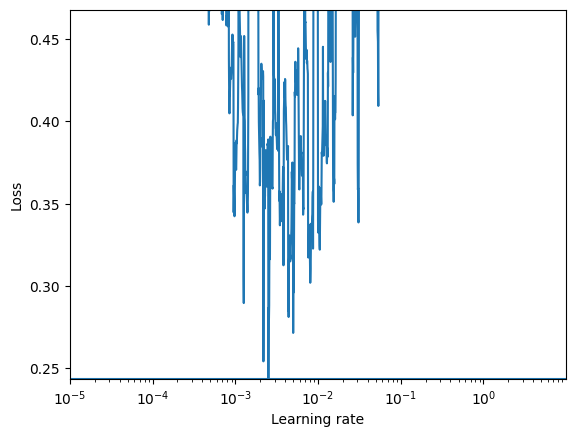

In [ ]:
model_2 = keras.models.clone_model(model_2)
model_2.compile(optimizer='Nadam',
                loss='binary_crossentropy')

rate, loss = find_learning_rate(model_2, X_para_train, y_para_train['cNEU'], epochs=100, batch_size=64)
plot_lr_vs_loss(rate, loss)

print(rate[np.argmin(loss)]/10)

In [ ]:
model_4 = keras.models.clone_model(model_4)
model_4.compile(optimizer='nadam',
                loss='binary_crossentropy')

rate, loss = find_learning_rate(model_4, X_para_train, y_para_train['cNEU'], epochs=100, batch_size=64, min_rate = 10**-10)
plot_lr_vs_loss(rate, loss)

print(rate[np.argmin(loss)]/10)

## Training the Neural Networks

In [ ]:
# Create the models
model_2_cEXT = keras.models.clone_model(model_2)
model_2_cNEU = keras.models.clone_model(model_2)
model_2_cAGR = keras.models.clone_model(model_2)
model_2_cCON = keras.models.clone_model(model_2)
model_2_cOPN = keras.models.clone_model(model_2)
model_2s = [model_2_cEXT, model_2_cNEU, model_2_cAGR, model_2_cCON, model_2_cOPN]

model_4_cEXT = keras.models.clone_model(model_4)
model_4_cNEU = keras.models.clone_model(model_4)
model_4_cAGR = keras.models.clone_model(model_4)
model_4_cCON = keras.models.clone_model(model_4)
model_4_cOPN = keras.models.clone_model(model_4)
model_4s = [model_4_cEXT, model_4_cNEU, model_4_cAGR, model_4_cCON, model_4_cOPN]

# The training sets (particularly the labels) are small, so I can get away with this for brevity
valid_ys = [y_para_valid['cEXT'], y_para_valid['cNEU'], y_para_valid['cAGR'], y_para_valid['cCON'], y_para_valid['cOPN']]
train_data = [tf_train_cEXT, tf_train_cNEU, tf_train_cAGR, tf_train_cCON, tf_train_cOPN]

# Stop the training when validation error plateaus
earlystopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)


# Compile the models
for model in model_2s:
  optimizer_2 = keras.optimizers.Nadam(learning_rate=0.0002)
  model.compile(optimizer=optimizer_2,
                loss='binary_crossentropy',
                metrics=['accuracy'])
for model in model_4s:
  optimizer_4 = keras.optimizers.Nadam(learning_rate=0.002)
  model.compile(optimizer=optimizer_4,
                loss='binary_crossentropy',
                metrics=['accuracy']) 


# Train the model that halves the size
train_acc_2 = []
valid_acc_2 = []
epoch_acc_2 = []
for model, X, valid_y in zip(model_2s, train_data, valid_ys):
  hist = model.fit(X, 
                     epochs=1000,
                     validation_data=[X_para_valid, valid_y],
                     callbacks=[earlystopping_cb])
  train_acc_2.append(hist.history['accuracy'])
  valid_acc_2.append(hist.history['val_accuracy'])
  epoch_acc_2.append(range(1, len(hist.history['accuracy']) + 1))


# Train the model that reduces the size by a factor of 4 each time
train_acc_4 = []
valid_acc_4 = []
epoch_acc_4 = []
for model, X, valid_y in zip(model_4s, train_data, valid_ys):
  hist = model.fit(X, 
                     epochs=1000,
                     validation_data=[X_para_valid, valid_y],
                     callbacks=[earlystopping_cb])
  train_acc_4.append(hist.history['accuracy'])
  valid_acc_4.append(hist.history['val_accuracy'])
  epoch_acc_4.append(range(1, len(hist.history['accuracy']) + 1))


Epoch 1/1000
25/25 [==============================] - 6s 17ms/step - loss: 0.6952 - accuracy: 0.5044 - val_loss: 0.6878 - val_accuracy: 0.5570
Epoch 2/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.6849 - accuracy: 0.5703 - val_loss: 0.6811 - val_accuracy: 0.5570
Epoch 3/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6765 - accuracy: 0.5849 - val_loss: 0.6774 - val_accuracy: 0.5570
Epoch 4/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6674 - accuracy: 0.6052 - val_loss: 0.6756 - val_accuracy: 0.5570
Epoch 5/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6588 - accuracy: 0.6191 - val_loss: 0.6725 - val_accuracy: 0.5696
Epoch 6/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6496 - accuracy: 0.6362 - val_loss: 0.6714 - val_accuracy: 0.5747
Epoch 7/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6396 - accuracy: 0.6502 - val_loss: 0.6702 - val_accuracy: 0.5899
Epoc

In [ ]:
# Save the models
path = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/pass_1/'

model_2_cEXT.save(path + 'model_2_cEXT')
model_2_cNEU.save(path + 'model_2_cNEU')
model_2_cAGR.save(path + 'model_2_cAGR')
model_2_cCON.save(path + 'model_2_cCON')
model_2_cOPN.save(path + 'model_2_cOPN')

model_4_cEXT.save(path + 'model_4_cEXT')
model_4_cNEU.save(path + 'model_4_cNEU')
model_4_cAGR.save(path + 'model_4_cAGR')
model_4_cCON.save(path + 'model_4_cCON')
model_4_cOPN.save(path + 'model_4_cOPN')

In [ ]:
# Save the data pertaining to accuracy at each epoch
path = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/pass_1/Training_Progress/'
np.save(path + 'train_acc_4', train_acc_4)
np.save(path + 'valid_acc_4', valid_acc_4)
np.save(path + 'epoch_acc_4', epoch_acc_4)

np.save(path + 'train_acc_2', train_acc_2)
np.save(path + 'valid_acc_2', valid_acc_2)
np.save(path + 'epoch_acc_2', epoch_acc_2)

In [ ]:
# Load the data pertaining to accuracy at each epoch
path = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/pass_1/Training_Progress/'
train_acc_4 = np.load(path + 'train_acc_4.npy', allow_pickle=True)
valid_acc_4 = np.load(path + 'valid_acc_4.npy', allow_pickle=True)
epoch_acc_4 = np.load(path + 'epoch_acc_4.npy', allow_pickle=True)

train_acc_2 = np.load(path + 'train_acc_2.npy', allow_pickle=True)
valid_acc_2 = np.load(path + 'valid_acc_2.npy', allow_pickle=True)
epoch_acc_2 = np.load(path + 'epoch_acc_2.npy', allow_pickle=True)


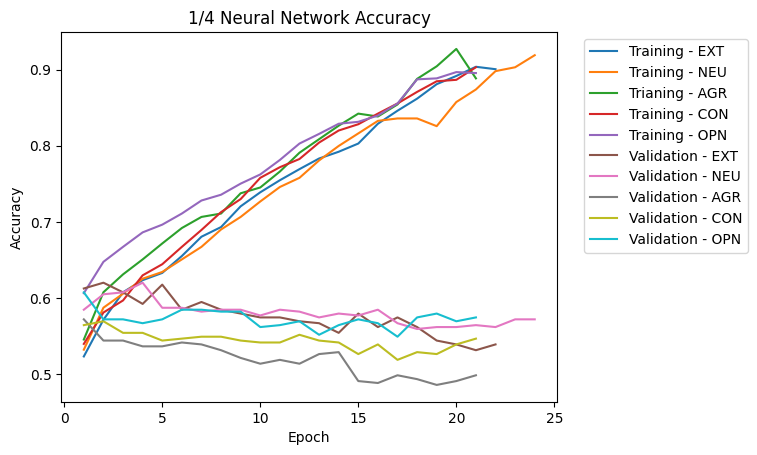

In [ ]:
labels_train = ['Training - EXT', 'Training - NEU', 'Trianing - AGR', 'Training - CON', 'Training - OPN']
labels_valid = ['Validation - EXT', 'Validation - NEU', 'Validation - AGR', 'Validation - CON', 'Validation - OPN']

for epochs, acc, label in zip(epoch_acc_4, train_acc_4, labels_train):
  plt.plot(epochs, acc, label=label)

for epochs, acc, label in zip(epoch_acc_4, valid_acc_4, labels_valid):
  plt.plot(epochs, acc, label=label)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('1/4 Neural Network Accuracy')

plt.show()

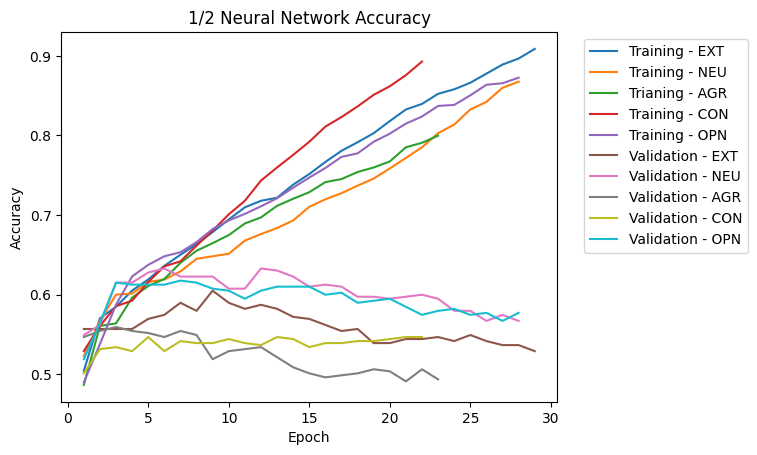

In [ ]:
labels_train = ['Training - EXT', 'Training - NEU', 'Trianing - AGR', 'Training - CON', 'Training - OPN']
labels_valid = ['Validation - EXT', 'Validation - NEU', 'Validation - AGR', 'Validation - CON', 'Validation - OPN']

for epochs, acc, label in zip(epoch_acc_2, train_acc_2, labels_train):
  plt.plot(epochs, acc, label=label)

for epochs, acc, label in zip(epoch_acc_2, valid_acc_2, labels_valid):
  plt.plot(epochs, acc, label=label)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('1/2 Neural Network Accuracy')

plt.show()

In [ ]:
cEXT_2_loss, cEXT_2_accuracy = model_2_cEXT.evaluate(X_para_valid, y_para_valid['cEXT'])
cNEU_2_loss, cNEU_2_accuracy = model_2_cNEU.evaluate(X_para_valid, y_para_valid['cNEU'])
cAGR_2_loss, cAGR_2_accuracy = model_2_cAGR.evaluate(X_para_valid, y_para_valid['cAGR'])
cCON_2_loss, cCON_2_accuracy = model_2_cCON.evaluate(X_para_valid, y_para_valid['cCON'])
cOPN_2_loss, cOPN_2_accuracy = model_2_cOPN.evaluate(X_para_valid, y_para_valid['cOPN'])

print()

cEXT_4_loss, cEXT_4_accuracy = model_4_cEXT.evaluate(X_para_valid, y_para_valid['cEXT'])
cNEU_4_loss, cNEU_4_accuracy = model_4_cNEU.evaluate(X_para_valid, y_para_valid['cNEU'])
cAGR_4_loss, cAGR_4_accuracy = model_4_cAGR.evaluate(X_para_valid, y_para_valid['cAGR'])
cCON_4_loss, cCON_4_accuracy = model_4_cCON.evaluate(X_para_valid, y_para_valid['cCON'])
cOPN_4_loss, cOPN_4_accuracy = model_4_cOPN.evaluate(X_para_valid, y_para_valid['cOPN'])


13/13 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.6152

13/13 [==============================] - 0s 4ms/step - loss: 0.6670 - accuracy: 0.6076


# Evaluation

See how our models perform on the test data.

## Neural Network

In [ ]:
# Parse the test data into paragraphs and sentences
X_sent_test, y_sent_test, X_para_test, y_para_test = prep_data(test_set)

# Load the models
path_1 = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/pass_1/'

model_2_cEXT = keras.models.load_model(path_1 + 'model_2_cEXT')
model_2_cNEU = keras.models.load_model(path_1 + 'model_2_cNEU')
model_2_cAGR = keras.models.load_model(path_1 + 'model_2_cAGR')
model_2_cCON = keras.models.load_model(path_1 + 'model_2_cCON')
model_2_cOPN = keras.models.load_model(path_1 + 'model_2_cOPN')

model_4_cEXT = keras.models.load_model(path_1 + 'model_4_cEXT')
model_4_cNEU = keras.models.load_model(path_1 + 'model_4_cNEU')
model_4_cAGR = keras.models.load_model(path_1 + 'model_4_cAGR')
model_4_cCON = keras.models.load_model(path_1 + 'model_4_cCON')
model_4_cOPN = keras.models.load_model(path_1 + 'model_4_cOPN')

In [ ]:
cEXT_2_loss, cEXT_2_accuracy = model_2_cEXT.evaluate(X_para_test, y_para_test['cEXT'])
cNEU_2_loss, cNEU_2_accuracy = model_2_cNEU.evaluate(X_para_test, y_para_test['cNEU'])
cAGR_2_loss, cAGR_2_accuracy = model_2_cAGR.evaluate(X_para_test, y_para_test['cAGR'])
cCON_2_loss, cCON_2_accuracy = model_2_cCON.evaluate(X_para_test, y_para_test['cCON'])
cOPN_2_loss, cOPN_2_accuracy = model_2_cOPN.evaluate(X_para_test, y_para_test['cOPN'])

print()

cEXT_4_loss, cEXT_4_accuracy = model_4_cEXT.evaluate(X_para_test, y_para_test['cEXT'])
cNEU_4_loss, cNEU_4_accuracy = model_4_cNEU.evaluate(X_para_test, y_para_test['cNEU'])
cAGR_4_loss, cAGR_4_accuracy = model_4_cAGR.evaluate(X_para_test, y_para_test['cAGR'])
cCON_4_loss, cCON_4_accuracy = model_4_cCON.evaluate(X_para_test, y_para_test['cCON'])
cOPN_4_loss, cOPN_4_accuracy = model_4_cOPN.evaluate(X_para_test, y_para_test['cOPN'])

16/16 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6336

16/16 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.6478


In [ ]:
print(np.mean([cEXT_4_accuracy, cNEU_4_accuracy, cAGR_4_accuracy, cCON_4_accuracy, cOPN_4_accuracy]))
print(np.mean([cEXT_2_accuracy, cNEU_2_accuracy, cAGR_2_accuracy, cCON_2_accuracy, cOPN_2_accuracy]))

0.5817813634872436
0.57773277759552


In [ ]:
model_4_cEXT.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 96)                36960     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 96)                0         
                                                                 
 dense_21 (Dense)            (None, 24)                2328      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 24)                0         
                                                                 
 dense_22 (Dense)            (None, 6)                 150       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 6)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               73920     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                18528     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                4656      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 48)                0         
                                                                 
 dense_3 (Dense)             (None, 24)                1

## Random Forests

The below classifiers were trained without examining the validation data.

In [ ]:
# Parse the test data into paragraphs and sentences
X_sent_test, y_sent_test, X_para_test, y_para_test = prep_data(test_set)

y_para_pred_cEXT = rf_clf_para_cEXT.predict(X_para_test)
y_para_pred_cNEU = rf_clf_para_cNEU.predict(X_para_test)
y_para_pred_cAGR = rf_clf_para_cAGR.predict(X_para_test)
y_para_pred_cCON = rf_clf_para_cCON.predict(X_para_test)
y_para_pred_cOPN = rf_clf_para_cOPN.predict(X_para_test)

acc_cEXT = accuracy_score(y_para_test['cEXT'], y_para_pred_cEXT)
acc_cNEU = accuracy_score(y_para_test['cNEU'], y_para_pred_cNEU)
acc_cAGR = accuracy_score(y_para_test['cAGR'], y_para_pred_cAGR)
acc_cCON = accuracy_score(y_para_test['cCON'], y_para_pred_cCON)
acc_cOPN = accuracy_score(y_para_test['cOPN'], y_para_pred_cOPN)

print(acc_cEXT)
print(acc_cNEU)
print(acc_cAGR)
print(acc_cCON)
print(acc_cOPN)
print()
print(np.mean([acc_cEXT, acc_cNEU, acc_cAGR, acc_cCON, acc_cOPN]))

0.5465587044534413
0.5728744939271255
0.5364372469635628
0.5566801619433198
0.6255060728744939

0.5676113360323887


The below code re-trains the random forests on the training+validation data.

In [ ]:
# What if we include the validation while creating the random forests?

X_sent_train, y_sent_train, X_para_train, y_para_train = prep_data(train_set)

rf_clf_para_cEXT = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cNEU = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cAGR = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cCON = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cOPN = RandomForestClassifier(max_features="sqrt",
                                          warm_start=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          n_estimators=800)

rf_clf_para_cEXT.fit(X_para_train, y_para_train['cEXT'])
rf_clf_para_cNEU.fit(X_para_train, y_para_train['cNEU'])
rf_clf_para_cAGR.fit(X_para_train, y_para_train['cAGR'])
rf_clf_para_cCON.fit(X_para_train, y_para_train['cCON'])
rf_clf_para_cOPN.fit(X_para_train, y_para_train['cOPN'])

y_para_pred_cEXT = rf_clf_para_cEXT.predict(X_para_test)
y_para_pred_cNEU = rf_clf_para_cNEU.predict(X_para_test)
y_para_pred_cAGR = rf_clf_para_cAGR.predict(X_para_test)
y_para_pred_cCON = rf_clf_para_cCON.predict(X_para_test)
y_para_pred_cOPN = rf_clf_para_cOPN.predict(X_para_test)

acc_cEXT = accuracy_score(y_para_test['cEXT'], y_para_pred_cEXT)
acc_cNEU = accuracy_score(y_para_test['cNEU'], y_para_pred_cNEU)
acc_cAGR = accuracy_score(y_para_test['cAGR'], y_para_pred_cAGR)
acc_cCON = accuracy_score(y_para_test['cCON'], y_para_pred_cCON)
acc_cOPN = accuracy_score(y_para_test['cOPN'], y_para_pred_cOPN)

path = '/content/drive/MyDrive/Colab Notebooks/Personality_Types/Models/random_forest_train_valid/'

pickle.dump(rf_clf_para_cEXT, open(path+'rc_clf_para_cEXT', 'wb'))
pickle.dump(rf_clf_para_cNEU, open(path+'rc_clf_para_cNEU', 'wb'))
pickle.dump(rf_clf_para_cAGR, open(path+'rc_clf_para_cAGR', 'wb'))
pickle.dump(rf_clf_para_cCON, open(path+'rc_clf_para_cCON', 'wb'))
pickle.dump(rf_clf_para_cOPN, open(path+'rc_clf_para_cOPN', 'wb'))

print(acc_cEXT)
print(acc_cNEU)
print(acc_cAGR)
print(acc_cCON)
print(acc_cOPN)
print()
print(np.mean([acc_cEXT, acc_cNEU, acc_cAGR, acc_cCON, acc_cOPN]))

0.5910931174089069
0.5587044534412956
0.548582995951417
0.5668016194331984
0.6194331983805668

0.576923076923077
